# Histopathologic Cancer Detection with Convolutional Neural Networks

This project implements a convolutional neural network (CNN) to classify images for the Histopathologic Cancer Detection dataset. The dataset contains a large number of small pathology images for binary classification of metastatic cancer. The goal is to predict whether a given image contains cancerous cells or not. The dataset is obtained from the Kaggle competition [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection)

Each image has a dimension of 96x96 pixels and is represented as a 3-channel RGB image. The dataset is split into a training set and a test set. The training set contains 220,025 images and the test set contains 57,458 images. The images are labeled as 0 or 1, where 0 indicates the absence of cancerous cells and 1 indicates the presence of cancerous cells.


The file structure is as follows:
```
input/
    train/
        00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif
        000020de2aa6193f4c160e398a8edea95b1da598.tif
        ...
    test/
        00006537328c33e284c973d7b39d340809f7271b.tif
        0000ec92553fda4ce39889f9226ace43cae3364e.tif
        ...
    train_labels.csv
    sample_submission.csv
```

The `train` folder contains the training images and the `test` folder contains the test images. The `train_labels.csv` file contains the labels for the training images. The `sample_submission.csv` file contains the image IDs and the corresponding predictions. The final submission file will contain the image IDs and the corresponding predictions for the test images.

For this project we will use TensorFlow and Keras to build the CNN model. The model will be trained on the training dataset and evaluated on the split validation dataset. The model will predict the test set for the competition submission.

The steps involved in the project are:
1. Define the file paths and load the dataset
2. Preprocess the datasets to prepare them for training and testing
3. Explore the dataset to understand the data (EDA)
4. Build the CNN model
5. Train the model
6. Evaluate the model
7. Predict the test set for the competition submission
8. Submit the predictions to Kaggle

In [45]:
# Import all necessary libraries for the project 
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

### Step 1: Define the file paths and load the dataset

In [46]:
# Define paths for the data
BASE_PATH = './histopathologic-cancer-detection'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
TEST_PATH = os.path.join(BASE_PATH, 'test')
TRAIN_LABELS_PATH = os.path.join(BASE_PATH, 'train_labels.csv')

# Load the training labels from the csv file
train_labels = pd.read_csv(TRAIN_LABELS_PATH)

### Step 2: Preprocess the datasets to prepare them for training and testing

In [47]:
# Create a function to process images to be used in the model
def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((96, 96))  # Resize the images for project requirements
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    return img_array

In [48]:
# Function to prepare datasets
def create_dataset(image_ids, labels=None, is_train=True):
    def gen():
        for i, id in enumerate(image_ids):
            image_path = os.path.join(TRAIN_PATH if is_train else TEST_PATH, f"{id}.tif")
            img = load_image(image_path)
            if labels is not None:
                yield img, labels.iloc[i]
            else:
                yield img
    
    if labels is not None:
        output_signature = (
            tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    else:
        output_signature = tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32)
    
    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=output_signature
    )
    
    return dataset

In [49]:
# Split data in the training folder into train and validation sets
train_ids, val_ids, train_labels, val_labels = train_test_split(
    train_labels['id'], train_labels['label'], test_size=0.2, random_state=12
)

# Configure the datasets for training
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Calculate steps per epoch
train_steps_per_epoch = len(train_ids) // BATCH_SIZE
val_steps_per_epoch = len(val_ids) // BATCH_SIZE

train_dataset = create_dataset(train_ids, train_labels)
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)

val_dataset = create_dataset(val_ids, val_labels)
val_dataset = val_dataset.batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)

# Prepare the test dataset for cometition predictions
test_ids = [filename.split('.')[0] for filename in os.listdir(TEST_PATH) if filename.endswith('.tif')]
test_dataset = create_dataset(test_ids, labels=None, is_train=False)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)  # Ensure no repeat() here

### Step 3: Explore the dataset to understand the data (EDA)

Previously we have prepared our datasets. We had prepared the pixel values to be between 0 and 1 for our CNN model for data cleaning. We had also split the training dataset into training and validation datasets. Now we will explore the dataset to understand the data better.

In [55]:
# Inspect the proportions of each label in the dataset 
train_labels.value_counts(normalize=True)

label
0    0.595256
1    0.404744
Name: proportion, dtype: float64

As seen above there is a slight imbalance for the labels, but for a medical dataset this imbalance is not so bad in comparison to other datasets. This should be ok for our training. 

2024-07-14 02:32:17.996965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


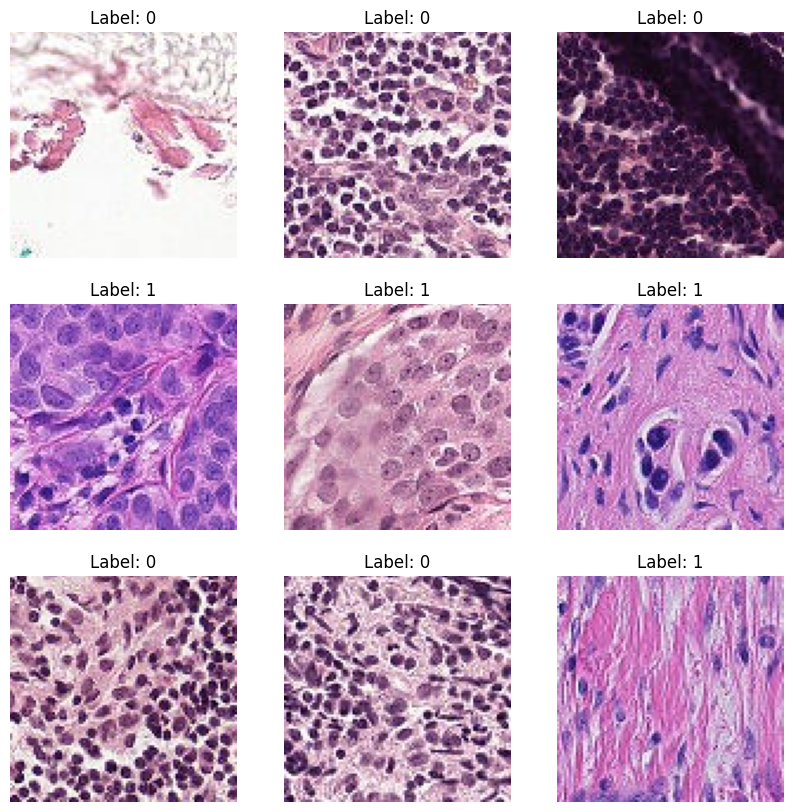

In [50]:
# Display the first 9 images from the training dataset
for img, label in train_dataset.take(1):
    # print shape of the images
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i])
        plt.title(f"Label: {label[i]}")
        plt.axis("off")

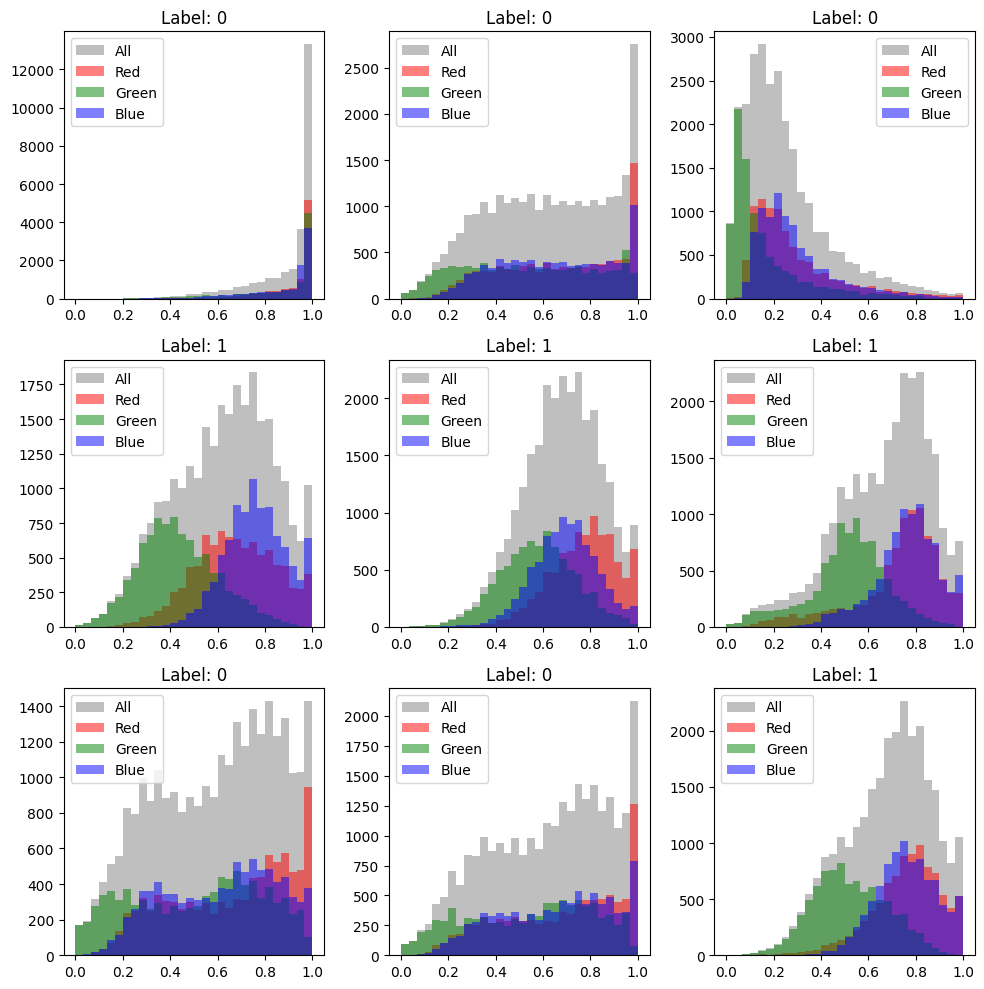

In [51]:
# Plot the RGB histograms of the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image_array = img[i].numpy() # Convert to numpy array
    plt.hist(image_array.ravel(), bins=30, range=[0, 1], color='gray', alpha=0.5, label='All')
    plt.hist(image_array[:, :, 0].ravel(), bins=30, range=[0, 1], color='red', alpha=0.5, label='Red')
    plt.hist(image_array[:, :, 1].ravel(), bins=30, range=[0, 1], color='green', alpha=0.5, label='Green')
    plt.hist(image_array[:, :, 2].ravel(), bins=30, range=[0, 1], color='blue', alpha=0.5, label='Blue')
    plt.title(f"Label: {label[i]}")
    plt.legend()
    plt.axis("on")  
plt.tight_layout()
plt.show()

As seen above the pixel values fall between 0 and 1, as we had coded them. We can also see that the images are in RGB format with the sample distributions of the RGB histograms. 

### Step 4: Build the CNN model

In [52]:
# Model creation function 
def create_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(96, 96, 3)))  # 96x96 RGB images
    model.add(layers.Conv2D(32, 3, activation="relu"))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Conv2D(64, 3, activation="relu"))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Conv2D(64, 3, activation="relu"))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    return model

### Step 5: Train the model 

In [53]:
model = create_model()
model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    epochs=10,  # Increase the number of epochs
    callbacks=callbacks
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,638,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,694,849 (6.47 MB)

 Trainable params: 1,694,849 (6.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
 121/5500 ━━━━━━━━━━━━━━━━━━━━ 5:28 61ms/step - accuracy: 0.6013 - auc: 0.5701 - loss: 0.7146

KeyboardInterrupt: 

### Step 6: Evaluate the model

In [ ]:
# Plotting the training history again
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.legend()
plt.title('AUC')

plt.show()

In [ ]:
# Ensure that the test dataset is correctly batched and does not repeat
predictions = model.predict(test_dataset, verbose=1)

# Round the predictions to 0 or 1
rounded_predictions = np.round(predictions).astype(int)

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_ids,
    'label': rounded_predictions.flatten()
})

# Save submission to CSV
submission.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")

# Optionally, you can print out a few predictions to verify
print(submission.head(10))
